<h1>2.2Calibarcion de imagenes de Bias

The purpose of calibrating bias images is threefold:

Subtract overscan if you have decided your science will be better if you subtract overscan. See this discussion of overscan for some guidance.

Trim the overscan region off of the image if it is present, regardless of whether or not you have chosen to subtract the overscan.

Combine the bias images into a “combined” bias to be used in calibrating the rest of the images. The purpose of combining several images is to reduce as much as possible the read noise in the combined bias.

The approach in this notebook will be to reduce a single image, look at the effects the reduction step had on that image and then demonstrate how to calibrate a folder containing several images of that type.

In [1]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.visualization import hist
import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from convenience_functions import show_image

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

<h1>2.2.2. Example 1: With overscan subtraction

<h1>2.2.2.1. Decide where to put your Example 1 calibrated images

In [4]:
calibrated_data = Path('.', 'example1-reduced')
calibrated_data.mkdir(exist_ok=True)

<h1>2.2.2.2. Make an image file collection for the raw data

In [5]:
example_cryo_path = Path('example-cryo-LFC')
files = ccdp.ImageFileCollection(example_cryo_path)

In [6]:
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str14,str9,str2,float64,int32,int32
ccd.001.0.fits,BIAS,i',0.0,2080,4128
ccd.002.0.fits,BIAS,i',0.0,2080,4128
ccd.003.0.fits,BIAS,i',0.0,2080,4128
ccd.004.0.fits,BIAS,i',0.0,2080,4128
ccd.005.0.fits,BIAS,i',0.0,2080,4128
ccd.006.0.fits,BIAS,i',0.0,2080,4128
ccd.014.0.fits,FLATFIELD,g',70.001,2080,4128
ccd.015.0.fits,FLATFIELD,g',70.011,2080,4128
ccd.016.0.fits,FLATFIELD,g',70.001,2080,4128


In [7]:
darks_only = ccdp.ImageFileCollection(example_cryo_path / 'darks')
darks_only.summary['file', 'imagetyp', 'exptime']

file,imagetyp,exptime
str14,str4,float64
ccd.002.0.fits,BIAS,0.0
ccd.013.0.fits,DARK,300.0
ccd.014.0.fits,DARK,300.0
ccd.015.0.fits,DARK,300.0
ccd.017.0.fits,DARK,70.0
ccd.018.0.fits,DARK,70.0
ccd.019.0.fits,DARK,70.0
ccd.023.0.fits,DARK,7.0
ccd.024.0.fits,DARK,7.0


<h1>2.2.2.3. Determinar la región de sobreexploración para el LFC Chip 0

Consulte la discusión de esta cámara en el cuaderno Overscan para conocer la región de overscan apropiada para usar con esta cámara. Tenga en cuenta, en particular, que difiere del valor dado en la BIASSECpalabra clave en el encabezado de las imágenes.

El paquete afiliado a astropy ccdproc proporciona dos funciones útiles aquí:

subtract_overscanpara restar el overscan de la imagen, y

trim_imagepara recortar el overscan.

Primero, veamos los valores de BIASSEC, que a veces (pero no siempre) indican que hay un overscan y qué parte del chip es el overscan, así como los valores de CCDSEC, que a veces está presente, pero no siempre, e indica qué parte del impacto de la luz del chip.

Tenga en cuenta que ninguno de estos es estándar; a veces, por ejemplo, trimsecse usa en lugar de ccdsec, y es probable que haya otras variantes. Algunas imágenes pueden no tener ninguna palabra clave en el encabezado. Esto no indica necesariamente que overserscan no esté presente. El mejor consejo es revisar cuidadosamente la documentación de la cámara que está utilizando.

In [8]:
files.summary['file', 'imagetyp', 'biassec', 'ccdsec', 'datasec'][0]

file,imagetyp,biassec,ccdsec,datasec
str14,str9,str18,str15,str15
ccd.001.0.fits,BIAS,"[2049:2080,1:4127]","[1:2048,1:4128]","[1:2048,1:4128]"


El encabezado de ajustes afirma que el overscan se extiende desde el 2049columna hasta el final de la imagen (esta es una indexación basada en uno) y que la parte de la imagen expuesta a la luz se extiende sobre todas las filas y desde la primera columna hasta la 2048columna (nuevamente, esto es un índice).

<h1>2.2.2.4. FITS vs. indexación de Python 

Hay dos diferencias entre FITS y Python en términos de indexación:

Los índices de Python se basan en cero (es decir, la numeración comienza en cero), mientras que los índices FITS se basan en uno (es decir, la numeración comienza en uno).

Se intercambia el orden de los índices.

Por ejemplo, la representación FITS de la parte del chip expuesta a la luz es [1:2048,1:4128]. Para acceder a esa parte de los datos desde una matriz NumPy en Python , cambie el orden para que la indexación se vea así: (o, de forma más compacta ). Tenga en cuenta que los índices finales proporcionados aquí para Python son correctos porque la segunda parte de un rango (después de los dos puntos) no está incluida en el segmento de la matriz. Por ejemplo, comienza en 0 (el primer píxel) y sube hasta 2048 pero no lo incluye, por lo que el último píxel incluido es (el 2048[0:4128, 0:2048][:, :2048]0:20482047 píxel).

Como se discutió en el cuaderno Overscan , la región de overscan útil para esta cámara comienza en 2055columna, no la columna 2049 como lo indica la BIASSECpalabra clave en el encabezado. Esta situación no es inusual; la columna 2049 es la primera de las columnas enmascaradas de la luz por el fabricante, pero hay alguna fuga en esta región desde el resto del CCD.

Si va a utilizar la sobreexploración, debe examinar cuidadosamente la sobreexploración en algunas imágenes representativas para comprender qué parte de la sobreexploración debe usar.

En lo que sigue, usaremos para el overscan la región (indexación de Python/NumPy) .[:, 2055:]

<h1>2.2.2.5. Restar y luego recortar el overscan (una imagen de muestra) 

In [9]:
raw_biases = files.files_filtered(include_path=True, imagetyp='BIAS')


In [10]:
first_bias = CCDData.read(raw_biases[0], unit='adu')

In [11]:
bias_overscan_subtracted = ccdp.subtract_overscan(first_bias, overscan=first_bias[:, 2055:], median=True)

In [12]:
trimmed_bias = ccdp.trim_image(bias_overscan_subtracted[:, :2048])

Text(0.5, 1.0, 'Bias, overscan subtracted and trimmed')

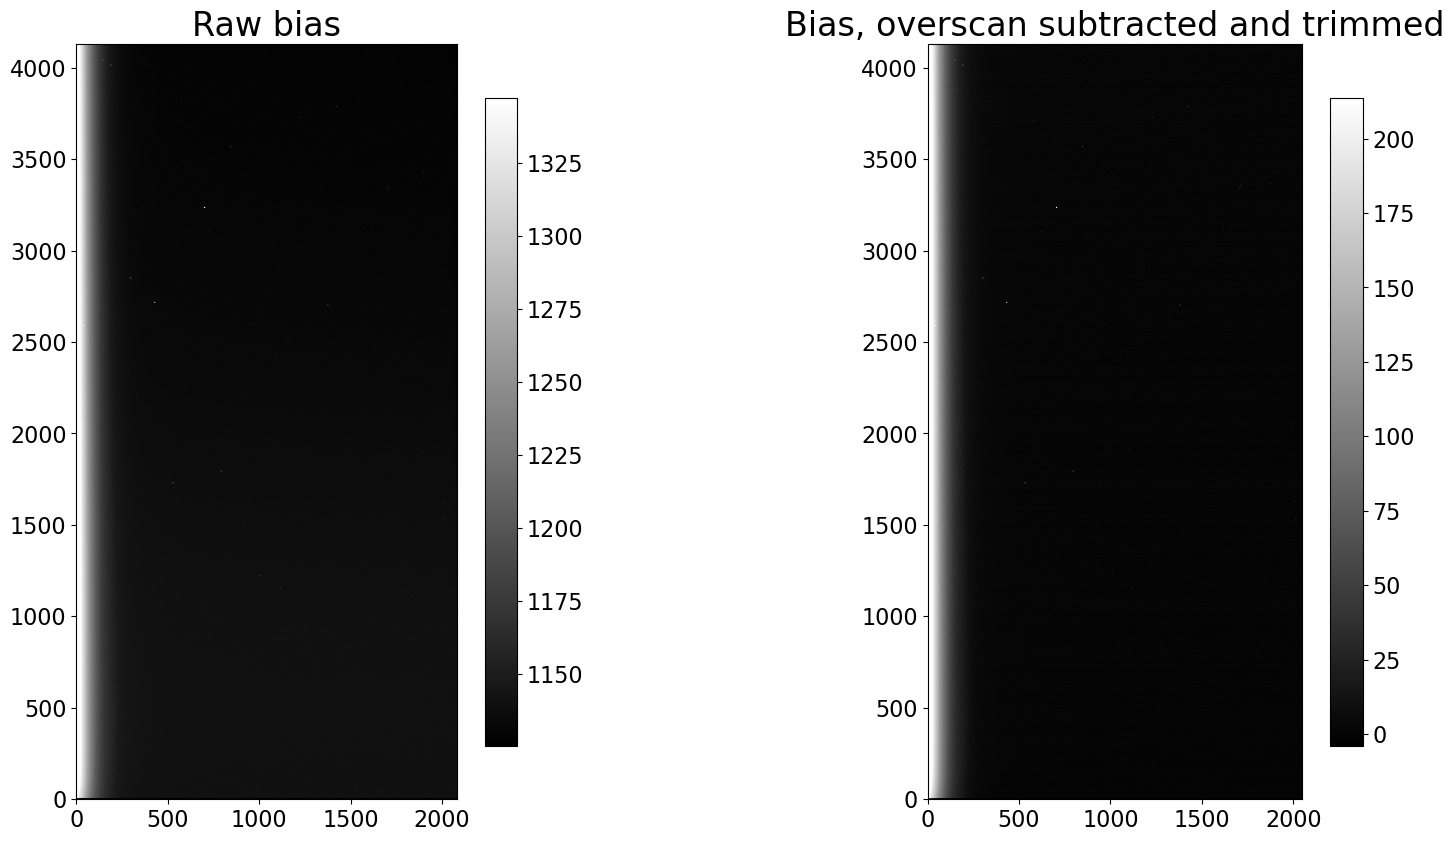

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(first_bias.data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Raw bias')
show_image(trimmed_bias.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('Bias, overscan subtracted and trimmed')

<h1>2.2.2.6. Discusión

Visualmente, las imágenes se ven casi idénticas antes y después de la calibración. La única diferencia destacada es un cambio en los valores de los píxeles, como cabría esperar al restar el mismo valor de cada píxel de una imagen. Simplemente cambia el punto cero.

Hay otra diferencia importante entre las imágenes: la imagen de entrada utiliza 32 MB de memoria, mientras que la imagen calibrada con sobreexploración utiliza aproximadamente 128 MB. La imagen de entrada se almacena como enteros de 16 bits sin signo; la imagen calibrada se almacena como números de punto flotante, que por defecto en Python son flotantes de 64 bits. El tamaño de la memoria es también el tamaño que tendrán los archivos cuando se escriban en el disco (ignorando cualquier compresión). Puede reducir la memoria y el espacio en disco cambiando el dtypede la imagen: . Es mejor hacer esto justo antes de escribir la imagen porque las operaciones aritméticas en la imagen pueden convertirla de nuevo a .trimmed_bias.data = trimmed_bias.data.astype('float32')dtypefloat64

# 2.2.2.7. Procesando la carpeta de imágenes bias para el LFC Chip 0

Procesar cada una de las imágenes de sesgo individualmente sería tedioso, en el mejor de los casos. En cambio, podemos usar el ImageFileCollectionque creamos arriba para recorrer solo las imágenes de sesgo, guardando cada una en la carpeta calibrated_data. En este ejemplo, los archivos se guardan sin comprimir porque la biblioteca de Python para comprimir archivos gzip es extremadamente lenta.

In [14]:
for ccd, file_name in files.ccds(imagetyp='BIAS',            # Just get the bias frames
                                 ccd_kwargs={'unit': 'adu'}, # CCDData requires a unit for the image if 
                                                             # it is not in the header
                                 return_fname=True           # Provide the file name too.
                                ):
        # Subtract the overscan
    ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:, 2055:], median=True)
    
    # Trim the overscan
    ccd = ccdp.trim_image(ccd[:, :2048])
    
    # Save the result
    ccd.write(calibrated_data / file_name)

In [15]:
reduced_images = ccdp.ImageFileCollection(calibrated_data)
reduced_images.summary['file', 'imagetyp', 'naxis1', 'naxis2']

file,imagetyp,naxis1,naxis2
str14,str4,int32,int32
ccd.001.0.fits,BIAS,2048,4128
ccd.002.0.fits,BIAS,2048,4128
ccd.003.0.fits,BIAS,2048,4128
ccd.004.0.fits,BIAS,2048,4128
ccd.005.0.fits,BIAS,2048,4128
ccd.006.0.fits,BIAS,2048,4128


<h1>2.2.3. Ejemplo 2: No hay resta de overscan, pero recorta las imágenes

Si no está restando la sobreexploración, la única manipulación que debe hacer es recortar la sobreexploración de las imágenes. Si no hay una región de sobreexploración en sus imágenes, incluso eso es innecesario.

<h1>2.2.3.1. Decide dónde poner tus imágenes calibradas del Ejemplo 2

In [16]:
calibrated_data = Path('.', 'example2-reduced')
calibrated_data.mkdir(exist_ok=True)

In [17]:
files = ccdp.ImageFileCollection('example-thermo-electric')
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str31,str5,object,float64,int32,int32
AutoFlat-PANoRot-r-Bin1-001.fit,FLAT,r,1.0,4109,4096
AutoFlat-PANoRot-r-Bin1-002.fit,FLAT,r,1.0,4109,4096
AutoFlat-PANoRot-r-Bin1-003.fit,FLAT,r,1.0,4109,4096
AutoFlat-PANoRot-r-Bin1-004.fit,FLAT,r,1.0,4109,4096
AutoFlat-PANoRot-r-Bin1-005.fit,FLAT,r,1.0,4109,4096
AutoFlat-PANoRot-r-Bin1-006.fit,FLAT,r,1.02,4109,4096
AutoFlat-PANoRot-r-Bin1-007.fit,FLAT,r,1.06,4109,4096
AutoFlat-PANoRot-r-Bin1-008.fit,FLAT,r,1.11,4109,4096
AutoFlat-PANoRot-r-Bin1-009.fit,FLAT,r,1.16,4109,4096


<h1>2.2.3.2. Determinar la región de overscan para esta cámara 

In [18]:
files.summary['file', 'imagetyp', 'biassec', 'trimsec'][0]

file,imagetyp,biassec,trimsec
str31,str5,str11,str11
AutoFlat-PANoRot-r-Bin1-001.fit,FLAT,[4096:4109],"[1:4096, :]"


<h1>2.2.3.3. Recortar el overscan (una imagen de muestra)

In [19]:
raw_biases = files.files_filtered(include_path=True, imagetyp='BIAS')

first_bias = CCDData.read(raw_biases[0], unit='adu')

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [20]:
trimmed_bias_fits = ccdp.trim_image(first_bias, fits_section='[1:4096, :]')

In [21]:
trimmed_bias_python = ccdp.trim_image(first_bias[:, :4096])

In [22]:
np.testing.assert_allclose(trimmed_bias_python, trimmed_bias_fits)

<h1>2.2.3.4. Procesando la carpeta de imágenes bias para el Ejemplo 2

In [23]:
for ccd, file_name in files.ccds(imagetyp='BIAS',            # Just get the bias frames
                                 return_fname=True           # Provide the file name too.
                                ):    
    # Trim the overscan
    ccd = ccdp.trim_image(ccd[:, :4096])
    
    # Save the result
    ccd.write(calibrated_data / file_name)

<h1>2.2.4. Ejemplo 3: Sin overscan en absoluto

In [24]:
calibrated_data = Path('.', 'example3-reduced')
calibrated_data.mkdir(exist_ok=True)

biases = files.files_filtered(imagetyp='BIAS', include_path=True)

import shutil

for bias in biases:
    shutil.copy(bias, calibrated_data)